In [0]:
%pip install tensorflow==2.12.0
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 977.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [0]:
%pip install opencv-python joblib pandas numpy matplotlib seaborn tqdm scikit-learn keras
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 16.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc

2025-05-21 13:05:31.024658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data loading

In [0]:
test_path ='/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test/'

#"/content/drive/MyDrive/RAF-DB/test"
train_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'

#"/content/drive/MyDrive/RAF-DB/train"
test_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test_labels (1).csv'
#"/content/drive/MyDrive/RAF-DB/test_labels.csv"
train_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train_labels (1).csv'
 #"/content/drive/MyDrive/RAF-DB/train_labels.csv"


In [0]:
train_labels = pd.read_csv(train_label_path)
test_labels = pd.read_csv(test_label_path)

In [0]:
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
emotion_to_label = {emotion: label_id for label_id, emotion in enumerate(emotion_classes, start=1)}
emotion_to_label

{'surprise': 1,
 'fear': 2,
 'disgust': 3,
 'happy': 4,
 'sad': 5,
 'angry': 6,
 'neutral': 7}

In [0]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []

    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)

    return np.array(images), np.array(labels)

train_images, train_labels = load_data(train_path, emotion_to_label)
test_images, test_labels = load_data(test_path, emotion_to_label)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

(12271, 100, 100, 3)
(3068, 100, 100, 3)


#Inspect data proportionality

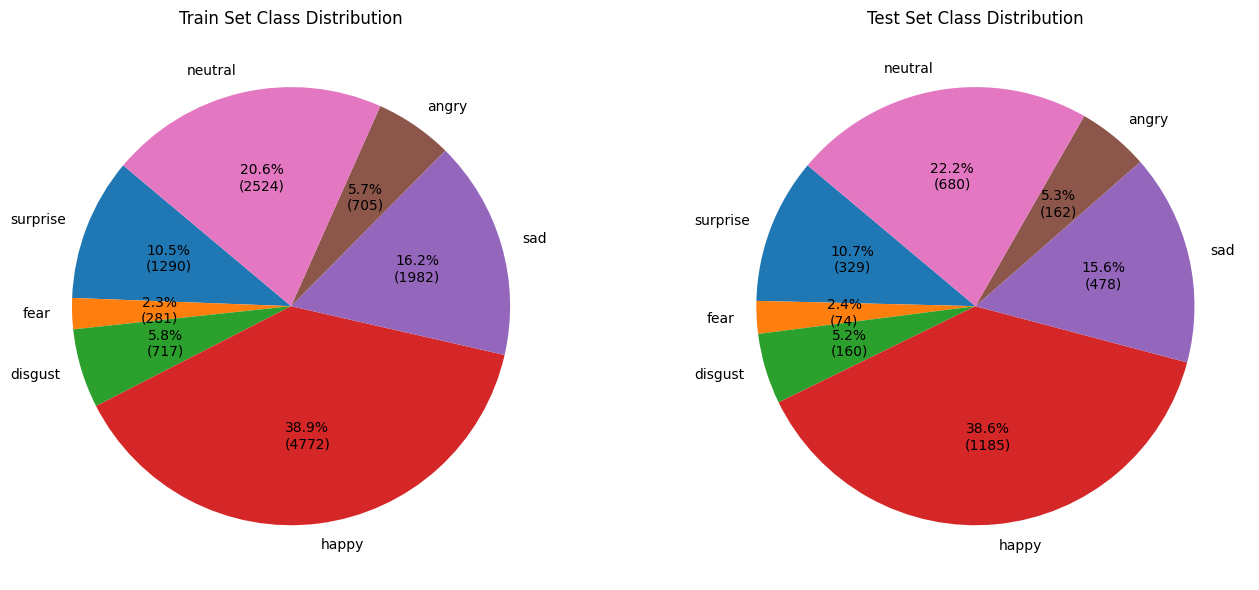

In [0]:
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return autopct

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(counts_train, labels=emotion_classes, autopct=make_autopct(counts_train), startangle=140)
axes[0].set_title('Train Set Class Distribution')

axes[1].pie(counts_test, labels=emotion_classes, autopct=make_autopct(counts_test), startangle=140)
axes[1].set_title('Test Set Class Distribution')

plt.tight_layout()
plt.show()


In [0]:
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


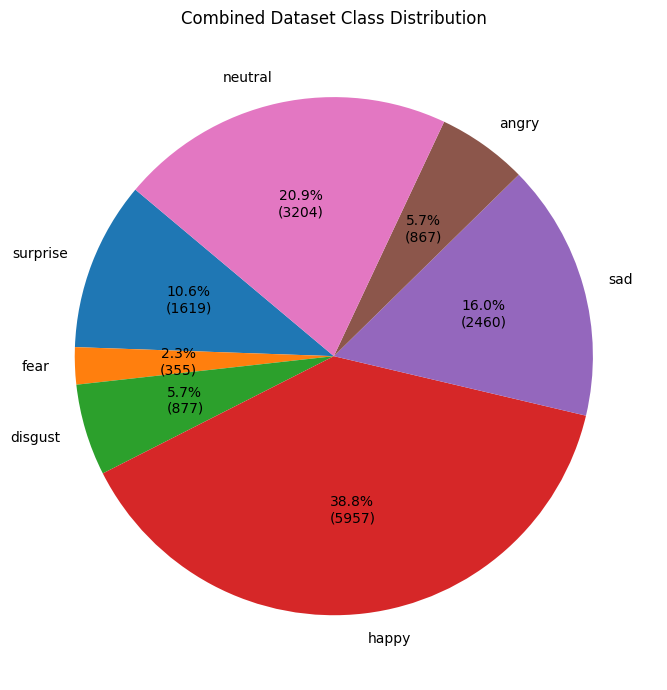

In [0]:
#Combined datasets
unique_combined, counts_combined = np.unique(Y_train, return_counts=True)
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return autopct

plt.figure(figsize=(7, 7))
plt.pie(counts_combined, labels=emotion_classes, autopct=make_autopct(counts_combined), startangle=140)
plt.title('Combined Dataset Class Distribution')
plt.tight_layout()
plt.show()

#Balancing the dataset

In [0]:
def reduce_class(X, y, target_class, target_size):

    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]

    return X_reduced, y_reduced

target_class = 4
target_size = 4000
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)

print(y_train_reduced.shape)
print(X_train_reduced.shape)

(13382,)
(13382, 100, 100, 3)


In [0]:
X_train_reduced[1]

array([[[ 86,  58,  46],
        [ 86,  58,  46],
        [ 88,  58,  47],
        ...,
        [ 42,  17,  21],
        [ 41,  16,  20],
        [ 48,  23,  27]],

       [[ 86,  58,  46],
        [ 86,  58,  46],
        [ 88,  58,  47],
        ...,
        [ 43,  18,  22],
        [ 41,  16,  20],
        [ 48,  23,  27]],

       [[ 87,  57,  46],
        [ 87,  57,  46],
        [ 87,  57,  46],
        ...,
        [ 46,  21,  25],
        [ 42,  17,  21],
        [ 47,  22,  26]],

       ...,

       [[136,  98,  97],
        [137,  99,  98],
        [131,  91,  89],
        ...,
        [ 51,  27,  41],
        [ 58,  34,  48],
        [ 68,  44,  58]],

       [[107,  69,  68],
        [122,  84,  83],
        [132,  92,  90],
        ...,
        [ 56,  32,  46],
        [ 61,  37,  51],
        [ 69,  45,  59]],

       [[ 81,  43,  42],
        [105,  67,  66],
        [124,  84,  82],
        ...,
        [ 57,  33,  47],
        [ 60,  36,  50],
        [ 66,  42,  56]]

In [0]:
def create_datagen():
  gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        vertical_flip=False,
        horizontal_flip=True,
        channel_shift_range=20.0,
        fill_mode='nearest',
        brightness_range=(0.8, 1.2))
  return gen

def augment_single_class(class_images, class_label, augment_count, datagen):
    augmented_imgs = []
    augmented_labels = []

    for batch in datagen.flow(class_images, batch_size=1, seed=42):
        aug_image = batch[0].astype(np.uint8)
        augmented_imgs.append(aug_image)
        augmented_labels.append(class_label)

        if len(augmented_imgs) >= augment_count:
            break

    return np.array(augmented_imgs), np.array(augmented_labels)


def augment_classes(images, labels, target_counts):

    datagen = create_datagen()
    augmented_images = images.copy()
    augmented_labels = labels.copy()

    for class_label, desired_count in target_counts.items():
        class_images = images[labels == class_label]
        current_count = len(class_images)
        augment_count = desired_count - current_count

        if augment_count > 0:
            print(f"Class {class_label}: {current_count} → augmenting with {augment_count} samples")

            new_imgs, new_labels = augment_single_class(class_images, class_label, augment_count, datagen)

            augmented_images = np.vstack((augmented_images, new_imgs))
            augmented_labels = np.hstack((augmented_labels, new_labels))

    return augmented_images, augmented_labels

In [0]:
target_counts = {1: 4000, 2: 4000, 3: 4000, 5: 4000, 6: 4000, 7: 4000}
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

Class 1: 1619 → augmenting with 2381 samples
Class 2: 355 → augmenting with 3645 samples
Class 3: 877 → augmenting with 3123 samples
Class 5: 2460 → augmenting with 1540 samples
Class 6: 867 → augmenting with 3133 samples
Class 7: 3204 → augmenting with 796 samples


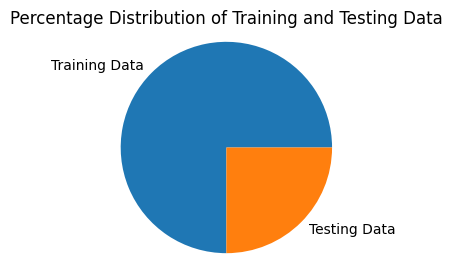

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented,
                                                    y_train_augmented,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

total_images = len(X_train) + len(X_test)
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100
plt.figure(figsize=(3, 3))
plt.pie([train_percentage, test_percentage], labels=['Training Data', 'Testing Data'])
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

# Normalization

In [0]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

# Reshaping for CNN

In [0]:
train_images_CNNreshaped = train_images_normalized.reshape((train_images_normalized.shape[0], 100, 100, 3))
test_images_CNNreshaped = test_images_normalized.reshape((test_images_normalized.shape[0], 100, 100, 3))

In [0]:
classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))

#CNN model

In [0]:
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Add, GlobalAveragePooling2D,
    Dense, Dropout, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    """
    Residual block with two convolutional layers and a skip connection
    """
    # Save input for the residual connection
    residual = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # If the number of filters or dimensions changed, we need to project the residual
    if strides != 1 or residual.shape[-1] != filters:
        residual = Conv2D(filters, 1, strides=strides, padding='same')(residual)
        residual = BatchNormalization()(residual)
    
    # Add the residual connection
    x = Add()([x, residual])
    x = Activation(activation)(x)
    
    return x

# Get input shape from your dataset
input_shape = test_images_CNNreshaped[0].shape

# Input layer
inputs = Input(shape=input_shape)

# Initial convolution
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# First residual block with 32 filters
x = residual_block(x, 32)
x = MaxPooling2D((2, 2))(x)

# Second residual block with 64 filters
x = residual_block(x, 64)
x = MaxPooling2D((2, 2))(x)

# Third residual block with 128 filters
x = residual_block(x, 128)
x = MaxPooling2D((2, 2))(x)

# Fourth residual block with 512 filters
x = residual_block(x, 512)
x = MaxPooling2D((2, 2))(x)

# Global pooling and dense layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(classes), activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-21 08:41:31.487192: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 100,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 100,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 100,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 50,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │      2,112 │ max_pooling2d[0]

 Total params: 12,772,999 (48.73 MB)

 Trainable params: 12,768,583 (48.71 MB)

 Non-trainable params: 4,416 (17.25 KB)

In [0]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-972fbf7d-f9c0-46dd-936f-9a6cfaacd66a/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

#Training

In [0]:
datagen =  ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                vertical_flip=False,
                horizontal_flip=True,
                channel_shift_range=20.0,
                fill_mode='nearest',
                brightness_range=(0.8, 1.2))

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

In [0]:
import tensorflow as tf
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

CNN_logs = model.fit(
    train_generator,
    epochs=60,
    steps_per_epoch=len(train_images_CNNreshaped) // 64,
    batch_size = 64,
    validation_data=(test_images_CNNreshaped, Y_test_cat),
    callbacks=[reduce_lr, early_stop, checkpoint]
)



Epoch 1/60
134/328 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.1412 - loss: 1.9461

*** WARNING: max output size exceeded, skipping output. ***

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1432 - loss: 1.9460
Epoch 1: val_accuracy improved from -inf to 0.15814, saving model to best_CNNModel.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.1432 - loss: 1.9460 - val_accuracy: 0.1581 - val_loss: 1.9458 - learning_rate: 1.0000e-04
Epoch 2/60
  1/328 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.1250 - loss: 1.9462

/local_disk0/.ephemeral_nfs/envs/pythonEnv-972fbf7d-f9c0-46dd-936f-9a6cfaacd66a/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.15814
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1250 - loss: 1.9462 - val_accuracy: 0.1549 - val_loss: 1.9458 - learning_rate: 1.0000e-04
Epoch 3/60
132/328 ━━━━━━━━━━━━━━━━━━━━ 27

*** WARNING: max output size exceeded, skipping output. ***

327/328 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.1503 - loss: 1.9447
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 11: val_accuracy did not improve from 0.15814
328/328 ━━━━━━━━━━━━━━━━━━━━ 48s 147ms/step - accuracy: 0.1503 - loss: 1.9447 - val_accuracy: 0.1456 - val_loss: 1.9471 - learning_rate: 1.0000e-04
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.


In [0]:
import os
SAVE_DIR = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f'
os.makedirs(SAVE_DIR, exist_ok=True)

# 3️⃣ (Optional) reload the best checkpoint and re-save it to Drive
from tensorflow.keras.models import load_model
best = load_model('best_CNNModel.keras')
best.save(os.path.join(SAVE_DIR, 'best_CNNModel.keras'))

In [0]:
CNN_logs.history.keys()

In [0]:
train_loss = CNN_logs.history['loss']
val_loss = CNN_logs.history['val_loss']
train_accuracy = CNN_logs.history['accuracy']
val_accuracy = CNN_logs.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy')
ax[1].plot(val_accuracy, label='Validation Accuracy')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [0]:
train_CNNresult = model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_CNNresult = model.evaluate(test_images_CNNreshaped, Y_test_cat)

print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

In [0]:
y_predCNN_prob = model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

In [0]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [0]:
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

#SQUEEZE-EXCITATION MODEL

# PREPROCESSING

In [0]:
dataset_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'


test_path ='/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test/'

#"/content/drive/MyDrive/RAF-DB/test"
train_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'

#"/content/drive/MyDrive/RAF-DB/train"
test_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test_labels (1).csv'
#"/content/drive/MyDrive/RAF-DB/test_labels.csv"
train_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train_labels (1).csv'
 #"/content/drive/MyDrive/RAF-DB/train_labels.csv"

In [0]:
image_counts = {}

for label in range(1, 8):  
    folder_path = os.path.join(dataset_path, str(label))
    image_counts[label] = len(os.listdir(folder_path))

In [0]:
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Label', 'Image Count'])

In [0]:
df_counts


,Label,Image Count
0,1,1290
1,2,281
2,3,717
3,4,4772
4,5,1982
5,6,705
6,7,2524


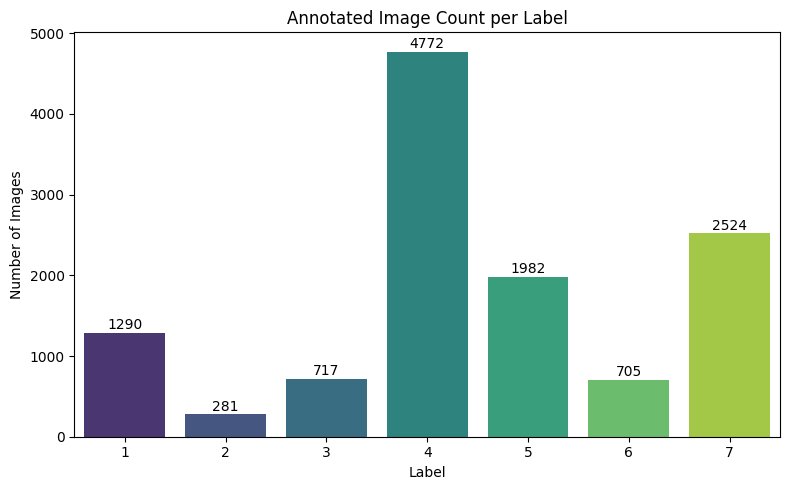

In [0]:
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Label', y='Image Count', data=df_counts, palette='viridis')

for index, row in df_counts.iterrows():
    bar_plot.text(row.name, row['Image Count'] + 5, round(row['Image Count'], 2), 
                  color='black', ha="center", va="bottom")

plt.title('Annotated Image Count per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

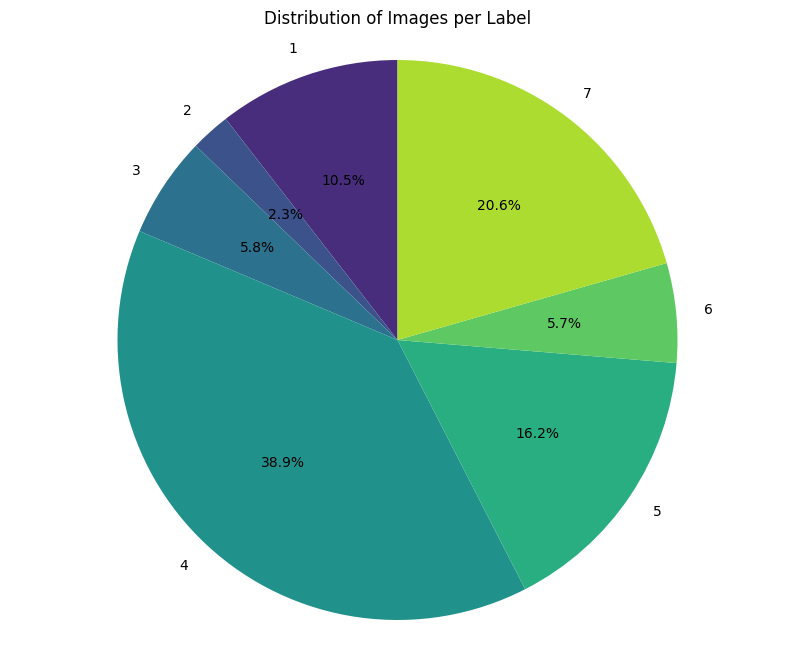

In [0]:
plt.figure(figsize=(10, 8))
plt.pie(df_counts['Image Count'], labels=df_counts['Label'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df_counts)))
plt.title('Distribution of Images per Label')
plt.axis('equal')  
plt.show()

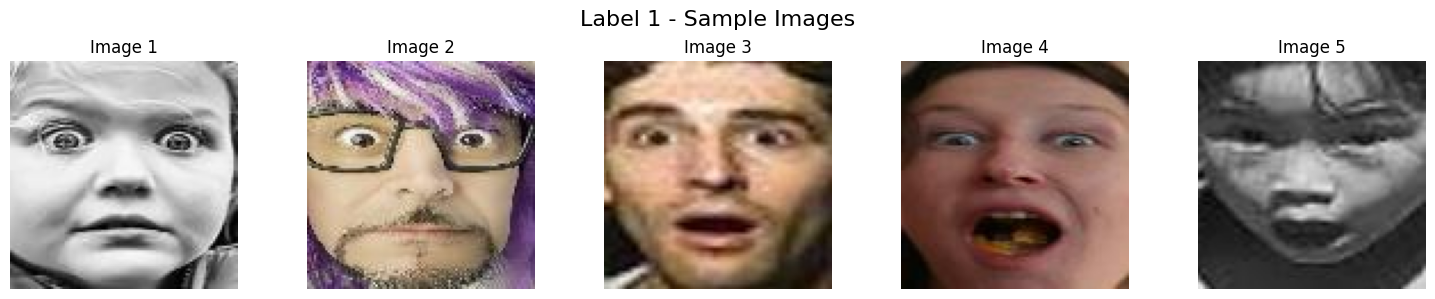

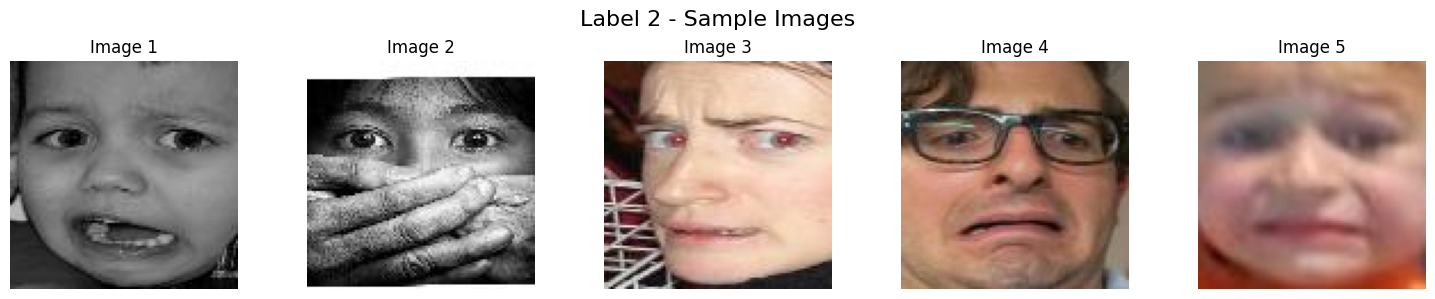

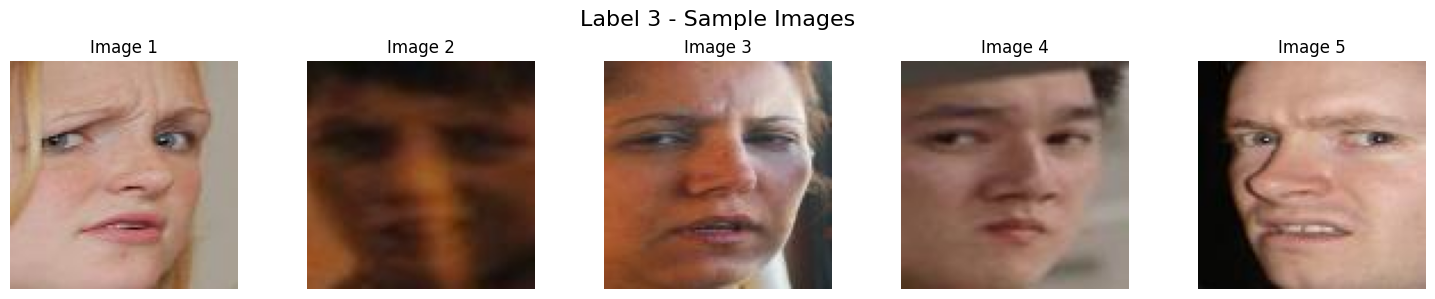

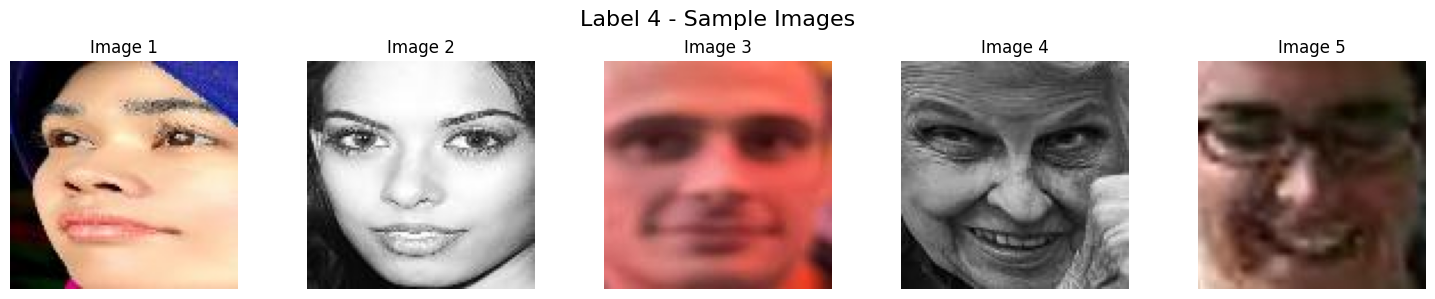

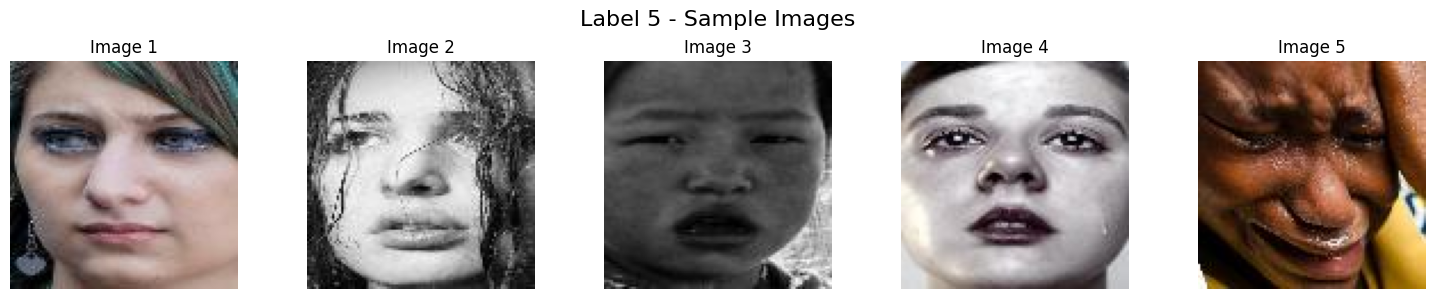

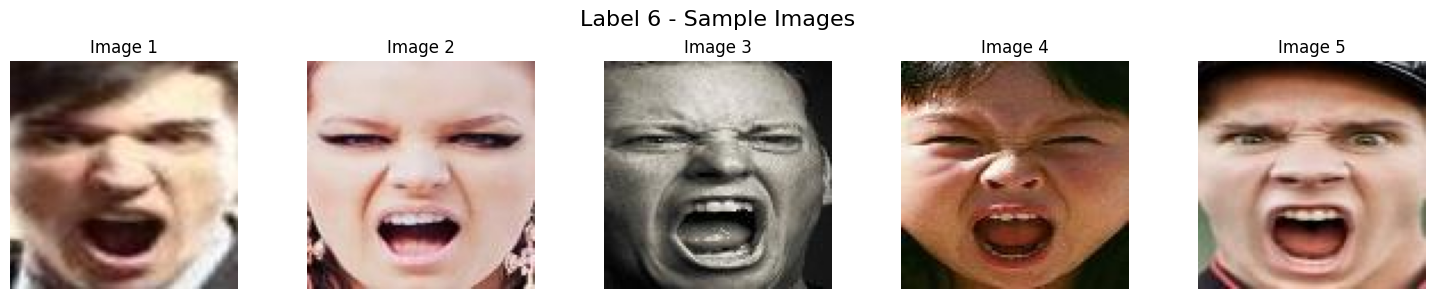

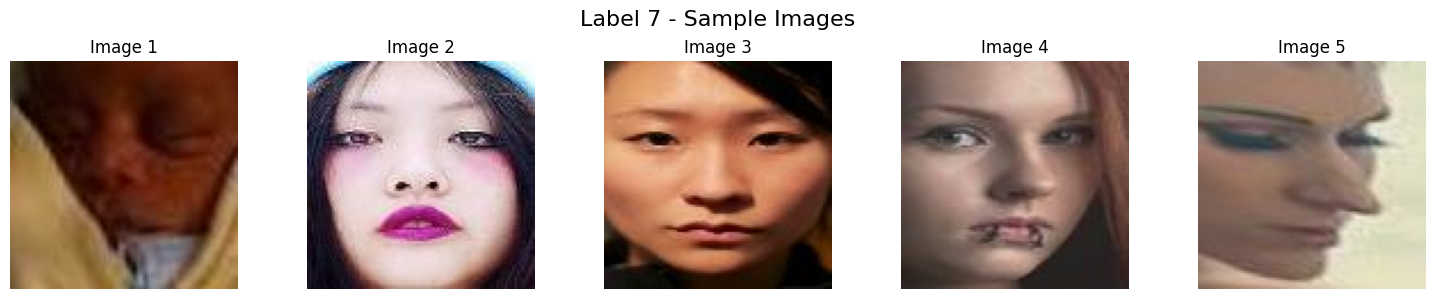

In [0]:
from PIL import Image
for label in range(1, 8):
    folder_path = os.path.join(dataset_path, str(label))
    image_files = os.listdir(folder_path)[:5]  

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Label {label} - Sample Images', fontsize=16)
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()

In [0]:
image_data = []

for label in range(1, 8):  
    folder_path = os.path.join(dataset_path, str(label))
    image_files = os.listdir(folder_path)
    
    for image_file in image_files:
        image_data.append((os.path.join(folder_path, image_file), label))

df = pd.DataFrame(image_data, columns=['image_path', 'label'])

In [0]:
print("Original class distribution:")
print(df['label'].value_counts())

Original class distribution:
4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: label, dtype: int64


In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['label'])
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['label'] = y_resampled
print("\nClass distribution after oversampling:")
print(df_resampled['label'].value_counts())


Class distribution after oversampling:
1    4772
2    4772
3    4772
4    4772
5    4772
6    4772
7    4772
Name: label, dtype: int64


In [0]:
df_resampled

,image_path,label
0,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,1
1,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,1
2,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,1
3,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,1
4,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,1
...,...,...
33399,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,7
33400,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,7
33401,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,7
33402,/dbfs/Workspace/Users/dimnaishvili@tbcbank.com...,7


In [0]:
import time
import shutil
import pathlib
import itertools

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [0]:
df_resampled['label'] = df_resampled['label'].astype(str)
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['label']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['label'] 
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='label',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 26723 validated image filenames belonging to 7 classes.
Found 3340 validated image filenames belonging to 7 classes.
Found 3341 validated image filenames belonging to 7 classes.


In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
# Uninstall any existing TF:
%pip uninstall -y tensorflow tf-nightly

# Install the last 2.12 release (built and tested for CUDA 11.8 on Linux):
%pip install tensorflow==2.12.0

dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.5 MB/s eta 0:00:00
     ━━

In [0]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


#MODEL TRAINING

In [0]:
class SEBlock(layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        se = self.squeeze(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = tf.reshape(se, [-1, 1, 1, tf.shape(inputs)[-1]])
        return inputs * se

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

inputs = layers.Input(shape=img_shape)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = SEBlock(512)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(7, activation="softmax")(x)  

model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile (Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy', metrics=["accuracy"])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 128)     7385

In [0]:
%pip install mlflow dagshub


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 9.6 MB/s eta 0:00:00
     ━━━━

In [0]:
import dagshub
dagshub.init(repo_name="Emotion_Recognition", repo_owner="dimna21", mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=31352ed0-cc8a-4623-88f0-03d2062ce9ee&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a576f3ea927ab9e366232f9f351b3df2a0fb6602d82f28d5974d63188e448472




Accessing as dimna21

Initialized MLflow to track repo "dimna21/Emotion_Recognition"

Repository dimna21/Emotion_Recognition initialized!

In [0]:
from dagshub import init
import mlflow
import mlflow.tensorflow

# (this will set MLFLOW_TRACKING_URI, USERNAME and PASSWORD for you)
init(repo_name="Emotion_Recognition", repo_owner="dimna21", mlflow=True)

# (optional) pick an experiment name
mlflow.set_experiment("Emotion_Recognition")

# enable automatic logging of all your args, metrics, metrics and models
mlflow.tensorflow.autolog()

# your existing callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=10,
    restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    filepath='/tmp/best_CNNModel',
    monitor='val_accuracy',
    save_best_only=True,
    save_format='tf'
)

# when you call fit(), MLflow will
# 1) automatically start a run
# 2) log hyper-params (optimizer, lr, etc),
# 3) log metrics each epoch,
# 4) capture your SavedModel artifact under Artifacts → model
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Initialized MLflow to track repo "dimna21/Emotion_Recognition"

Repository dimna21/Emotion_Recognition initialized!

2025/05/21 13:41:20 INFO mlflow.tracking.fluent: Experiment with name 'Emotion_Recognition' does not exist. Creating a new experiment.
2025/05/21 13:41:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '973b9cfe116c4ebc90229c9a31a98406', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/21 13:41:22 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/05/21 13:41:22 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/5


2025-05-21 13:41:33.626261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 143/1671 [=>....................

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 1.4392 - accuracy: 0.4547

2025-05-21 13:48:32.812547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1671/1671 [==============================] - 594s 353ms/step - loss: 1.4392 - accuracy: 0.4547 - val_loss: 0.8671 - val_accuracy: 0.6967
Epoch 2/5
 140/1671 [=>............................] - ETA: 6:35 - loss: 0.6674 - accuracy: 0.7612

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.8275

1671/1671 [==============================] - 479s 286ms/step - loss: 0.5124 - accuracy: 0.8275 - val_loss: 0.3827 - val_accuracy: 0.8656
Epoch 3/5
 140/1671 [=>............................] - ETA: 6:31 - loss: 0.2452 - accuracy: 0.9134

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9237

1671/1671 [==============================] - 478s 286ms/step - loss: 0.2384 - accuracy: 0.9237 - val_loss: 0.2611 - val_accuracy: 0.9186
Epoch 4/5
 140/1671 [=>............................] - ETA: 6:17 - loss: 0.1084 - accuracy: 0.9701

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9563

1671/1671 [==============================] - 596s 356ms/step - loss: 0.1454 - accuracy: 0.9563 - val_loss: 0.2679 - val_accuracy: 0.9260
Epoch 5/5
 140/1671 [=>............................] - ETA: 6:21 - loss: 0.1018 - accuracy: 0.9670

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - 473s 283ms/step - loss: 0.1110 - accuracy: 0.9668 - val_loss: 0.2821 - val_accuracy: 0.9201


2025/05/21 14:25:14 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/21 14:25:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [0]:
import shutil
shutil.copytree('/tmp/best_CNNModel',
                '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/best_CNNModel')

'/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/best_CNNModel'

In [0]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Accuracy: {test_accuracy:.2f}")

2025-05-21 14:30:12.954278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


209/209 [==============================] - 55s 254ms/step - loss: 0.2969 - accuracy: 0.9228
Test Accuracy: 0.92


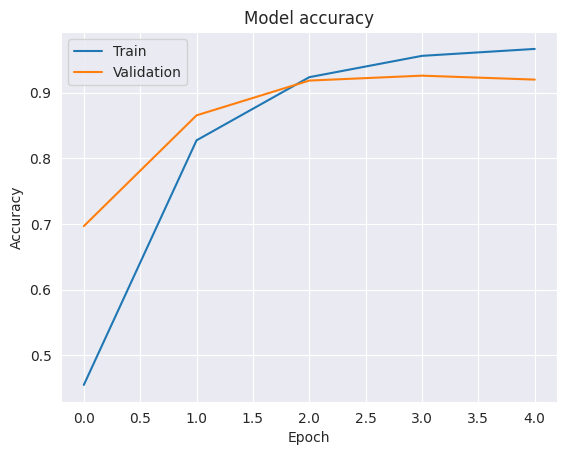

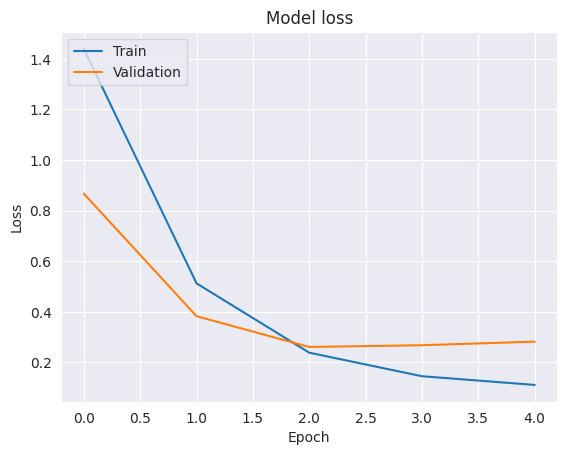

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
test_labels = test_gen_new.classes  
predictions = model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

2025-05-21 14:31:17.611948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


209/209 [==============================] - 55s 251ms/step


In [0]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       477
           2       0.98      0.99      0.99       477
           3       0.97      0.93      0.95       477
           4       0.94      0.80      0.86       477
           5       0.88      0.87      0.87       478
           6       0.97      1.00      0.98       477
           7       0.78      0.92      0.84       478

    accuracy                           0.92      3341
   macro avg       0.93      0.92      0.92      3341
weighted avg       0.93      0.92      0.92      3341



In [0]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

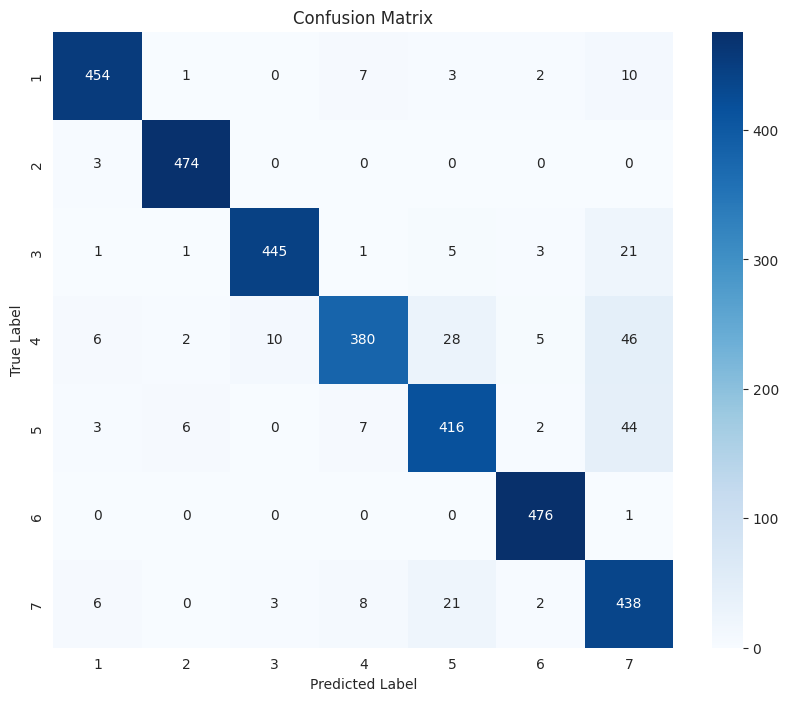

In [0]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()